<a href="https://colab.research.google.com/github/amcbhome/datasets/blob/main/AnomalyNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate synthetic dataset

In [4]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta

# ---------------------------
# Reproducibility & settings
# ---------------------------
np.random.seed(42)
random.seed(42)

N_JOURNALS = 300       # number of journals
MIN_LINES = 2          # min lines per journal
MAX_LINES = 4          # max lines per journal
YEAR = 2024
CURRENCY = "GBP"

# Chart of accounts (code, name, normal_balance)
ACCOUNTS = [
    (1000, "Cash at Bank", "D"),
    (1100, "Accounts Receivable", "D"),
    (1200, "Inventory", "D"),
    (1300, "Prepayments", "D"),
    (2000, "Accounts Payable", "C"),
    (2100, "Accruals", "C"),
    (3000, "Share Capital", "C"),
    (3100, "Retained Earnings", "C"),
    (4000, "Sales Revenue", "C"),
    (4100, "Other Income", "C"),
    (5000, "Cost of Goods Sold", "D"),
    (5100, "Wages Expense", "D"),
    (5200, "Rent Expense", "D"),
    (5300, "Utilities Expense", "D"),
    (5400, "Depreciation Expense", "D"),
    (5500, "Interest Expense", "D"),
]

DEPARTMENTS = ["FIN", "OPS", "MKT", "HR", "IT"]
USERS = ["U101", "U102", "U103", "U201", "U301", "U401"]
POSTING_TYPES = ["Manual", "Automated", "Reversal"]

def random_date_in_year(year: int) -> datetime:
    start = datetime(year, 1, 1)
    end = datetime(year, 12, 31)
    delta_days = (end - start).days
    return start + timedelta(days=int(np.random.randint(0, delta_days + 1)))

def make_amounts_k_sized(k: int, mean: float = 1000.0, sd: float = 500.0):
    """
    Create k positive amounts that sum to a random total (abs normal),
    then return the vector that sums exactly to total via final adjustment.
    """
    # draw base magnitudes
    raw = np.abs(np.random.normal(loc=mean, scale=sd, size=k))
    # avoid all zeros
    if raw.sum() == 0:
        raw = np.ones(k)
    total = np.abs(np.random.normal(loc=mean * 1.5, scale=sd * 1.5))
    # normalise to total
    parts = (raw / raw.sum()) * total
    # round to 2dp and fix rounding leak on last element
    parts = np.round(parts, 2)
    diff = np.round(total - parts.sum(), 2)
    parts[-1] = np.round(parts[-1] + diff, 2)
    return parts

rows = []
journal_counter = 0

for j in range(N_JOURNALS):
    journal_counter += 1
    journal_id = f"JRN-{YEAR}-{journal_counter:04d}"
    date = random_date_in_year(YEAR)

    # 2–4 lines per journal
    n_lines = random.randint(MIN_LINES, MAX_LINES)

    # Choose accounts (allow repeats but bias to variety)
    acct_idxs = np.random.choice(len(ACCOUNTS), size=n_lines, replace=True)
    accounts = [ACCOUNTS[i] for i in acct_idxs]

    # Decide how many debits vs credits; must have at least one of each
    n_debits = random.randint(1, n_lines - 1)
    n_credits = n_lines - n_debits

    debit_amts = make_amounts_k_sized(n_debits, mean=1200, sd=600)
    credit_amts = make_amounts_k_sized(n_credits, mean=1200, sd=600)

    # Force perfect balance by setting totals equal
    total_debit = np.round(debit_amts.sum(), 2)
    total_credit = np.round(credit_amts.sum(), 2)
    if total_debit != total_credit:
        # Adjust last credit to match
        credit_amts[-1] = np.round(credit_amts[-1] + (total_debit - total_credit), 2)
        total_credit = np.round(credit_amts.sum(), 2)

    # Build line-by-line
    line_roles = ["D"] * n_debits + ["C"] * n_credits
    random.shuffle(line_roles)

    # Assign amounts to roles
    d_ptr, c_ptr = 0, 0

    # Random context
    dept = random.choice(DEPARTMENTS)
    user = random.choice(USERS)
    approval = random.randint(1, 3)
    posting = random.choice(POSTING_TYPES)
    exch_rate = 1.0  # single currency for now

    # Heuristic anomaly flags
    #  - unusually large journal (> 25k total)
    #  - manual posting outside business hours (simulated via date on weekend)
    #  - concentration: same user posting many debits
    journal_total = total_debit
    is_weekend = date.weekday() >= 5  # 5=Sat, 6=Sun
    anomaly = int((journal_total > 25000) or (posting == "Manual" and is_weekend))

    for i in range(n_lines):
        acc_code, acc_name, _nb = accounts[i]
        role = line_roles[i]
        debit, credit = 0.0, 0.0
        if role == "D":
            amt = float(debit_amts[d_ptr]); d_ptr += 1
            debit = amt; credit = 0.0
        else:
            amt = float(credit_amts[c_ptr]); c_ptr += 1
            debit = 0.0; credit = amt

        # Simple auto-description
        if role == "D":
            desc = f"Dr to {acc_name}"
        else:
            desc = f"Cr to {acc_name}"

        rows.append({
            "Date": date.date().isoformat(),
            "Journal_ID": journal_id,
            "Line_No": i + 1,
            "Account_Code": acc_code,
            "Account_Name": acc_name,
            "Dept_Code": dept,
            "Description": desc,
            "Debit": round(debit, 2),
            "Credit": round(credit, 2),
            "User_ID": user,
            "Approval_Level": approval,
            "Posting_Type": posting,
            "Currency": CURRENCY,
            "Exchange_Rate": exch_rate,
            "Audit_Flag": anomaly
        })

df_gl = pd.DataFrame(rows)

# ---------------------------
# Validations
# ---------------------------
# 1) Journal-level balance check
check = df_gl.groupby("Journal_ID")[["Debit", "Credit"]].sum().round(2)
check["Balanced"] = np.isclose(check["Debit"], check["Credit"])
assert check["Balanced"].all(), "Some journals are not balanced!"

# 2) Compute Net per line (useful for Z-scores later)
df_gl["Net"] = (df_gl["Debit"] - df_gl["Credit"]).round(2)

# 3) A few patterned anomalies: multiply a handful of journals
for jid in random.sample(list(df_gl["Journal_ID"].unique()), k=max(1, N_JOURNALS // 30)):
    mask = df_gl["Journal_ID"] == jid
    df_gl.loc[mask, ["Debit", "Credit", "Net"]] = np.round(
        df_gl.loc[mask, ["Debit", "Credit", "Net"]] * random.choice([4, 6, 10]),
        2
    )
    df_gl.loc[mask, "Audit_Flag"] = 1

# ---------------------------
# Save
# ---------------------------
out_path = "/content/synthetic_gl_2024_balanced.csv"
df_gl.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(df_gl.head(10))
print("\nBalance summary (first 5):")
print(check.head())


Saved: /content/synthetic_gl_2024_balanced.csv
         Date     Journal_ID  Line_No  Account_Code          Account_Name  \
0  2024-04-12  JRN-2024-0001        1          1300           Prepayments   
1  2024-04-12  JRN-2024-0001        2          5200          Rent Expense   
2  2024-04-12  JRN-2024-0001        3          5400  Depreciation Expense   
3  2024-04-12  JRN-2024-0001        4          5000    Cost of Goods Sold   
4  2024-12-25  JRN-2024-0002        1          3100     Retained Earnings   
5  2024-12-25  JRN-2024-0002        2          1200             Inventory   
6  2024-11-09  JRN-2024-0003        1          2100              Accruals   
7  2024-11-09  JRN-2024-0003        2          5200          Rent Expense   
8  2024-07-06  JRN-2024-0004        1          5500      Interest Expense   
9  2024-07-06  JRN-2024-0004        2          5400  Depreciation Expense   

  Dept_Code                 Description    Debit   Credit User_ID  \
0       OPS           Cr to Prepayme

Save the dataset

In [5]:
from google.colab import files
files.download('/content/synthetic_gl_2024_balanced.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load and inspect the dataset

In [6]:
import pandas as pd

# Load your file (adjust path if needed)
df = pd.read_csv('/content/synthetic_gl_2024_balanced.csv')

# Preview & info
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            885 non-null    object 
 1   Journal_ID      885 non-null    object 
 2   Line_No         885 non-null    int64  
 3   Account_Code    885 non-null    int64  
 4   Account_Name    885 non-null    object 
 5   Dept_Code       885 non-null    object 
 6   Description     885 non-null    object 
 7   Debit           885 non-null    float64
 8   Credit          885 non-null    float64
 9   User_ID         885 non-null    object 
 10  Approval_Level  885 non-null    int64  
 11  Posting_Type    885 non-null    object 
 12  Currency        885 non-null    object 
 13  Exchange_Rate   885 non-null    float64
 14  Audit_Flag      885 non-null    int64  
 15  Net             885 non-null    float64
dtypes: float64(4), int64(4), object(8)
memory usage: 110.8+ KB


,Line_No,Account_Code,Debit,Credit,Approval_Level,Exchange_Rate,Audit_Flag,Net
count,885.000000,885.000000,885.000000,885.000000,885.000000,885.0,885.000000,8.850000e+02
mean,2.085876,3368.474576,724.265605,724.265605,2.014689,1.0,0.138983,6.166066e-15
std,0.981430,1691.852462,1162.095178,1422.274058,0.821659,0.0,0.346124,2.103244e+03
min,1.000000,1000.000000,0.000000,-2977.000000,1.000000,1.0,0.000000,-1.576180e+04
25%,1.000000,1300.000000,0.000000,0.000000,1.000000,1.0,0.000000,-1.150860e+03
50%,2.000000,3100.000000,45.390000,0.000000,2.000000,1.0,0.000000,1.399200e+02
75%,3.000000,5100.000000,1104.730000,1150.860000,3.000000,1.0,0.000000,1.123390e+03
max,4.000000,5500.000000,10674.080000,15761.800000,3.000000,1.0,1.000000,1.067408e+04


📊 Step 2 – Summarise journals and accounts

In [7]:
# Journal-level totals
journal_summary = df.groupby('Journal_ID')[['Debit','Credit']].sum()
journal_summary['Balance'] = journal_summary['Debit'] - journal_summary['Credit']
print(journal_summary.head())

# Account totals (trial-balance style)
trial_balance = df.groupby('Account_Name')[['Debit','Credit']].sum().round(2)
trial_balance['Net'] = trial_balance['Debit'] - trial_balance['Credit']
trial_balance.sort_values('Net', ascending=False).head(10)


                 Debit   Credit  Balance
Journal_ID                              
JRN-2024-0001  3031.61  3031.61      0.0
JRN-2024-0002  2288.30  2288.30      0.0
JRN-2024-0003  1293.94  1293.94      0.0
JRN-2024-0004  4103.54  4103.54      0.0
JRN-2024-0005  2652.70  2652.70      0.0


,Debit,Credit,Net
Account_Name,,,
Rent Expense,50558.65,19073.93,31484.72
Accounts Receivable,45693.55,32108.09,13585.46
Cost of Goods Sold,39832.23,27608.74,12223.49
Interest Expense,54311.59,42143.44,12168.15
Retained Earnings,53266.08,46224.05,7042.03
Prepayments,39619.15,33876.77,5742.38
Utilities Expense,35269.30,29584.71,5684.59
Other Income,51550.24,45919.99,5630.25
Cash at Bank,45223.56,42954.01,2269.55


🚨 Step 3 – Z-Score anomaly detection

In [8]:
from scipy.stats import zscore

# Compute net and z-score by journal
journal_summary['Net'] = journal_summary['Debit'] - journal_summary['Credit']
journal_summary['Z_Net'] = zscore(journal_summary['Net'])

# Flag outliers beyond ±3 SD
outliers = journal_summary[journal_summary['Z_Net'].abs() > 3]
print(f"{len(outliers)} journals flagged as potential anomalies")
outliers.head()


1 journals flagged as potential anomalies


,Debit,Credit,Balance,Net,Z_Net
Journal_ID,,,,,
JRN-2024-0219,15446.58,15446.58,-1.818989e-12,-1.818989e-12,-11.292066


In [9]:
df_out = df[df['Journal_ID'].isin(outliers.index)]


🧠 Step 4 – Benford’s Law (fraud screening idea)

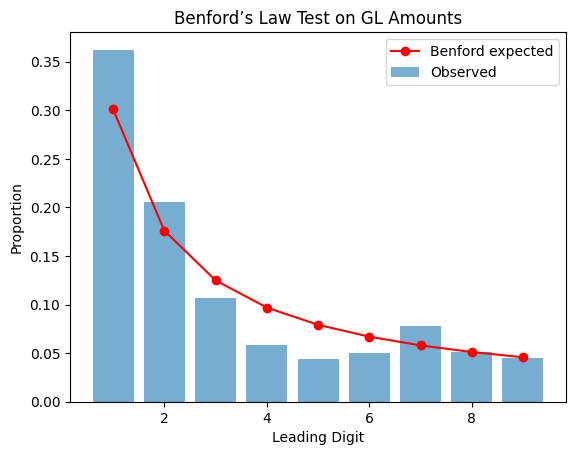

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Use absolute values of Debit/Credit
values = df[['Debit','Credit']].values.flatten()
values = values[values > 0]

first_digits = [int(str(int(v))[0]) for v in values if v > 0]
obs = pd.Series(first_digits).value_counts(normalize=True).sort_index()

# Expected Benford proportions
benford = np.log10(1 + 1/np.arange(1,10))

plt.bar(obs.index, obs.values, alpha=0.6, label='Observed')
plt.plot(range(1,10), benford, 'ro-', label='Benford expected')
plt.xlabel('Leading Digit')
plt.ylabel('Proportion')
plt.title('Benford’s Law Test on GL Amounts')
plt.legend()
plt.show()


🕵️ Step 5 – Visualise anomalies

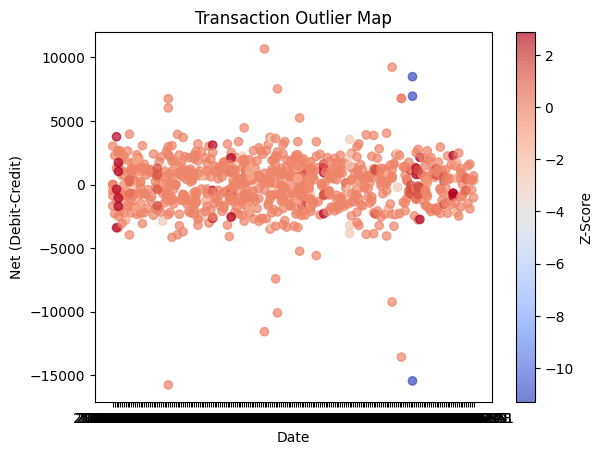

In [12]:
import matplotlib.pyplot as plt

# Add journal totals back to main frame
df = df.merge(journal_summary[['Z_Net']], left_on='Journal_ID', right_index=True, how='left')

plt.scatter(df['Date'], df['Debit'] - df['Credit'],
            c=df['Z_Net'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Z-Score')
plt.xlabel('Date')
plt.ylabel('Net (Debit-Credit)')
plt.title('Transaction Outlier Map')
plt.show()


🧾 Step 6 – Optional dashboards or Streamlit app

In [13]:
pip install streamlit plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.0 MB/s eta 0:00:00


In [14]:
import streamlit as st
import pandas as pd
import plotly.express as px

df = pd.read_csv('synthetic_gl_2024_balanced.csv')

st.title("Audit Analytics Dashboard")
st.metric("Total Debits", f"£{df['Debit'].sum():,.0f}")
st.metric("Total Credits", f"£{df['Credit'].sum():,.0f}")

outliers = df[df['Audit_Flag']==1]
st.write("### Flagged Transactions")
st.dataframe(outliers)

fig = px.scatter(df, x='Date', y='Debit', color='Audit_Flag',
                 title='Debit Distribution Over Time')
st.plotly_chart(fig)


2025-11-08 11:31:09.360 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-08 11:31:09.545 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-08 11:31:09.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-08 11:31:09.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-08 11:31:09.550 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-08 11:31:09.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-08 11:31:09.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-08 11:31:09.556 Thread 'MainThread': mi

DeltaGenerator()

In [15]:
import pandas as pd
from scipy.stats import zscore

# Load your synthetic GL
df = pd.read_csv('/content/synthetic_gl_2024_balanced.csv')

# Confirm structure
df.head()


,Date,Journal_ID,Line_No,Account_Code,Account_Name,Dept_Code,Description,Debit,Credit,User_ID,Approval_Level,Posting_Type,Currency,Exchange_Rate,Audit_Flag,Net
0,2024-04-12,JRN-2024-0001,1,1300,Prepayments,OPS,Cr to Prepayments,0.00,494.72,U102,1,Reversal,GBP,1.0,0,-494.72
1,2024-04-12,JRN-2024-0001,2,5200,Rent Expense,OPS,Cr to Rent Expense,0.00,856.75,U102,1,Reversal,GBP,1.0,0,-856.75
2,2024-04-12,JRN-2024-0001,3,5400,Depreciation Expense,OPS,Cr to Depreciation Expense,0.00,1680.14,U102,1,Reversal,GBP,1.0,0,-1680.14
3,2024-04-12,JRN-2024-0001,4,5000,Cost of Goods Sold,OPS,Dr to Cost of Goods Sold,3031.61,0.00,U102,1,Reversal,GBP,1.0,0,3031.61
4,2024-12-25,JRN-2024-0002,1,3100,Retained Earnings,FIN,Dr to Retained Earnings,2288.30,0.00,U101,1,Manual,GBP,1.0,0,2288.30


In [16]:
# Group by journal and compute totals
journal_summary = (
    df.groupby('Journal_ID')[['Debit', 'Credit']]
      .sum()
      .assign(Net=lambda x: x['Debit'] - x['Credit'])
)

# Compute z-scores on the Net column
journal_summary['Z_Net'] = zscore(journal_summary['Net'])

# Flag journals whose |Z| > 3
journal_summary['Outlier_Flag'] = (journal_summary['Z_Net'].abs() > 3).astype(int)

# Display only the flagged ones
outliers = journal_summary[journal_summary['Outlier_Flag'] == 1]
print(f"{len(outliers)} journals exceed ±3 SD:")
outliers.head()


1 journals exceed ±3 SD:


,Debit,Credit,Net,Z_Net,Outlier_Flag
Journal_ID,,,,,
JRN-2024-0219,15446.58,15446.58,-1.818989e-12,-11.292066,1


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Debit']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Debit'}, axis=1)
              .sort_values('Debit', ascending=True))
  xs = counted['Debit']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('Debit', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Debit')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Credit']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Credit'}, axis=1)
              .sort_values('Credit', ascending=True))
  xs = counted['Credit']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Credit', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Credit')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Net']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Net'}, axis=1)
              .sort_values('Net', ascending=True))
  xs = counted['Net']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Net', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Net')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Z_Net']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Z_Net'}, axis=1)
              .sort_values('Z_Net', ascending=True))
  xs = counted['Z_Net']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Z_Net', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Z_Net')
_ = plt.ylabel('count()')

In [18]:
# Assuming you already have journal_summary from earlier
outlier = journal_summary[journal_summary['Z_Net'].abs() > 3]
print(outlier[['Net', 'Z_Net']])


                        Net      Z_Net
Journal_ID                            
JRN-2024-0219 -1.818989e-12 -11.292066


In [19]:
# 1️⃣ Locate the outlier journal in the summary
outlier = journal_summary[journal_summary['Z_Net'].abs() > 3]
print(outlier[['Net', 'Z_Net']])


                        Net      Z_Net
Journal_ID                            
JRN-2024-0219 -1.818989e-12 -11.292066


In [20]:
# Filter for the target Journal ID
target_journal = "JRN-2024-0219"

record = df[df["Journal_ID"] == target_journal]

# Display full details
print(f"Records for {target_journal}:")
display(record)


Records for JRN-2024-0219:


,Date,Journal_ID,Line_No,Account_Code,Account_Name,Dept_Code,Description,Debit,Credit,User_ID,Approval_Level,Posting_Type,Currency,Exchange_Rate,Audit_Flag,Net
642,2024-07-31,JRN-2024-0219,1,5100,Wages Expense,IT,Cr to Wages Expense,0.00,15446.58,U201,2,Automated,GBP,1.0,1,-15446.58
643,2024-07-31,JRN-2024-0219,2,5500,Interest Expense,IT,Dr to Interest Expense,6956.94,0.00,U201,2,Automated,GBP,1.0,1,6956.94
644,2024-07-31,JRN-2024-0219,3,1200,Inventory,IT,Dr to Inventory,8489.64,0.00,U201,2,Automated,GBP,1.0,1,8489.64


In [21]:
# Choose the journal you want to inspect
jid = "JRN-2024-0219"

# Filter its records
entry = df[df["Journal_ID"] == jid]

# Display lines
display(entry)

# Sum debits and credits
total_debits = entry["Debit"].sum()
total_credits = entry["Credit"].sum()

print(f"\nJournal: {jid}")
print(f"Total Debits : £{total_debits:,.2f}")
print(f"Total Credits: £{total_credits:,.2f}")

# Check balance
if abs(total_debits - total_credits) < 0.01:
    print("✅ Journal is balanced.")
else:
    print("⚠️ Journal is NOT balanced — potential data entry error.")


,Date,Journal_ID,Line_No,Account_Code,Account_Name,Dept_Code,Description,Debit,Credit,User_ID,Approval_Level,Posting_Type,Currency,Exchange_Rate,Audit_Flag,Net
642,2024-07-31,JRN-2024-0219,1,5100,Wages Expense,IT,Cr to Wages Expense,0.00,15446.58,U201,2,Automated,GBP,1.0,1,-15446.58
643,2024-07-31,JRN-2024-0219,2,5500,Interest Expense,IT,Dr to Interest Expense,6956.94,0.00,U201,2,Automated,GBP,1.0,1,6956.94
644,2024-07-31,JRN-2024-0219,3,1200,Inventory,IT,Dr to Inventory,8489.64,0.00,U201,2,Automated,GBP,1.0,1,8489.64



Journal: JRN-2024-0219
Total Debits : £15,446.58
Total Credits: £15,446.58
✅ Journal is balanced.


In [22]:
import pandas as pd
from scipy.stats import zscore

# Load and compute z-scores by Journal_ID
df = pd.read_csv('/content/synthetic_gl_2024_balanced.csv')

journal_summary = (
    df.groupby('Journal_ID')[['Debit','Credit']]
      .sum()
      .assign(Net=lambda x: x['Debit'] - x['Credit'])
)
journal_summary['Z_Net'] = zscore(journal_summary['Net'])

# Merge back the Z-score to every line
df = df.merge(journal_summary[['Z_Net']], left_on='Journal_ID', right_index=True)

# Save file with Z-score included
df.to_csv('/content/synthetic_GL_with_Zscore.csv', index=False)
print("Saved: synthetic_GL_with_Zscore.csv")


Saved: synthetic_GL_with_Zscore.csv


In [23]:
subset = df[['Date','Journal_ID','Account_Code','Account_Name',
             'Dept_Code','Debit','Credit','Net','Z_Net']].head(500)

subset.to_latex('gl_records.tex', index=False, longtable=False, escape=False)
from google.colab import files
files.download('gl_records.tex')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>